<a href="https://colab.research.google.com/github/Callum-pb/python_projects/blob/master/Weight_tracker/weight_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes:

Tidy up or reformat some of the plots, including the grid lines and adding titles. Makeing text bigger, etc.

Is there a way of plotting the daily change in weight? 
Maybe show the largest daily delta, or the average weight shift each day.

Extended:
Plot other timeseries data onto the graph. Look into plotting my expenses on food vs time compared with the weight loss. Is there a pattern?

# Weight Log Analysis

A simple exploration of my daily weight log.

The goal of this notebook is to viusalise my weight loss journey and see what other information I can gain from some basic analysis.

## Import
Authenticate Google Sheets, import packages, import data

In [0]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import missingno

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1KYiph71L7fyHS01_X08fKKEb_9Ev3RCOeeeEkYQ8nFY/edit')

In [0]:
sheet = wb.worksheet('Weight Log')

In [0]:
data = sheet.get_all_values()

## Cleaning/EDA

In [0]:
# Create df from csv and see what it looks like
raw = pd.DataFrame(data)
raw.head(10)

,0,1,2,3,4,5,6
0,12/06/2020,kg,lbs,,,kg,lbs
1,Start Weight,130.9,288.0,,Goal Weight,100,220
2,Current Weight,,0.0,,Remaining,-100,-220
3,Weight Lost,130.9,288.0,,,,
4,,,,,,,
5,,,,,,,
6,Date,Weight (kg),7-day Avg,Daily Delta,,,
7,12/05/2019,130.9,-,-,,,
8,13/05/2019,127.8,-,-3.1,,,
9,14/05/2019,127.8,-,0,,,


We can see that the top of the CSV had some extra rows from analysis within the Google Sheet. We need to drop these in order to obtain our data table.

In [0]:
# Drop excess info rows
raw = raw.iloc[6:,:4]
raw.head()

,0,1,2,3
6,Date,Weight (kg),7-day Avg,Daily Delta
7,12/05/2019,130.9,-,-
8,13/05/2019,127.8,-,-3.1
9,14/05/2019,127.8,-,0
10,15/05/2019,128.7,-,0.9


Let's pull out the name our columns and drop the headers row. We can then also reindex our df. This will be our clean data.

I'm also going to drop the 7-day Avg column, and the Daily Delta column as I know there is missing data in the log and would like to handle recalculating these within this notebook. This gives me greater control.

In [0]:
clean = raw.iloc[1:,:2]
clean.columns = ['Date','Weight']
clean.reset_index(drop=True,inplace=True)
clean.head()

,Date,Weight
0,12/05/2019,130.9
1,13/05/2019,127.8
2,14/05/2019,127.8
3,15/05/2019,128.7
4,16/05/2019,128.5


Now let's check our data types and convert if needed.

In [0]:
clean.dtypes

Date      object
Weight    object
dtype: object

In [0]:
clean['Date'] = pd.to_datetime(clean['Date'],dayfirst=True)
clean['Weight'] = pd.to_numeric(clean['Weight'],errors='coerce')
clean.dtypes

Date      datetime64[ns]
Weight           float64
dtype: object

Now to check the validity of our data. 
First let's check see some basic stats

In [0]:
clean.describe()

,Weight
count,322.000000
mean,121.961056
std,5.761135
min,112.000000
25%,116.425000
50%,123.550000
75%,127.687500
max,130.900000


Min and Max weights looks to be valid. 

In [0]:
print(f'Min Date: {clean.Date.min()}')
print(f'Max Date: {clean.Date.max()}')

Min Date: 2019-05-12 00:00:00
Max Date: 2020-07-11 00:00:00


Min date looks valid. Earliest is when the log started. 
Max date is in the future, my guess is the data column in the CSV is dragged down for ease of entry. We should see plenty of missing values in the weight column corresponding to these future dates. If this is the case then I can either leave them in for forecasting purposes, or drop them for now to make the handling of current data easier.

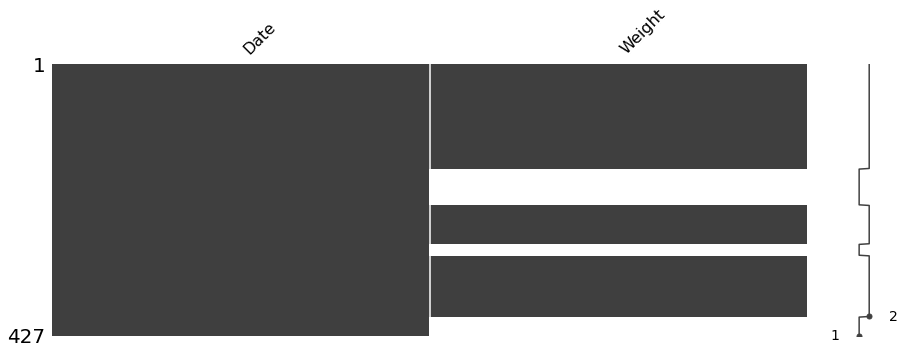

In [0]:
missingno.matrix(clean,figsize=(15,5))

We can see the future dates we previously mentioned. We can also see two large chunks missing. If I remember correctly, the first was when I moved cities and didn't keep up with my logging. The second was during my trip to Florida. I had no access to bathroom scales.

## Dealing with missing Data

I'm going to drop the future dates as I can always add them back in for forecasting or plotting purposes.

I will leave the missing data missing for now. However, I may add a new column and interpolate these gaps. This interpolated column will help with plotting a trend line later.

In [0]:
#First, let's drop the future dates
clean.tail(50)
#Probably a nicer way of finding the last rull row, but this does the job.

,Date,Weight
377,2020-05-23,114.85
378,2020-05-24,113.85
379,2020-05-25,114.30
380,2020-05-26,113.90
381,2020-05-27,113.45
382,2020-05-28,113.60
383,2020-05-29,113.75
384,2020-05-30,113.75
385,2020-05-31,113.60
386,2020-06-01,113.35


In [0]:
clean = clean.iloc[:391,:]
clean.tail()

,Date,Weight
386,2020-06-01,113.35
387,2020-06-02,112.75
388,2020-06-03,112.00
389,2020-06-04,112.10
390,2020-06-05,112.00


As I don't know which interpolation method will work best, I'll try a few and plot the resutls.

I'll also set the Date as the index. This allows better plotting using the Grouper method. It also allows time interpolation.

In [0]:
clean.set_index('Date',inplace=True)

clean['Linear'] = clean.Weight.interpolate(method='linear',axis=0).copy()
clean['Time'] = clean.Weight.interpolate(method='time',axis=0,).copy()
clean['Poly-5'] = clean.Weight.interpolate(method='time',axis=0,order=5).copy()
#There are many others to look at, but this is a start

In [0]:
clean.head()

,Weight,Linear,Time,Poly-5
Date,,,,
2019-05-12,130.9,130.9,130.9,130.9
2019-05-13,127.8,127.8,127.8,127.8
2019-05-14,127.8,127.8,127.8,127.8
2019-05-15,128.7,128.7,128.7,128.7
2019-05-16,128.5,128.5,128.5,128.5


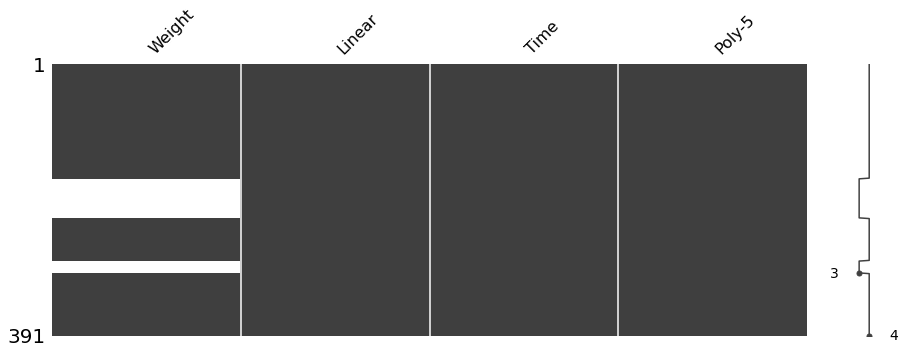

In [0]:
missingno.matrix(clean,figsize=(15,5))

## Time to plot it

I'd like to see how each interpolation compares, or if there was just too much data missing.

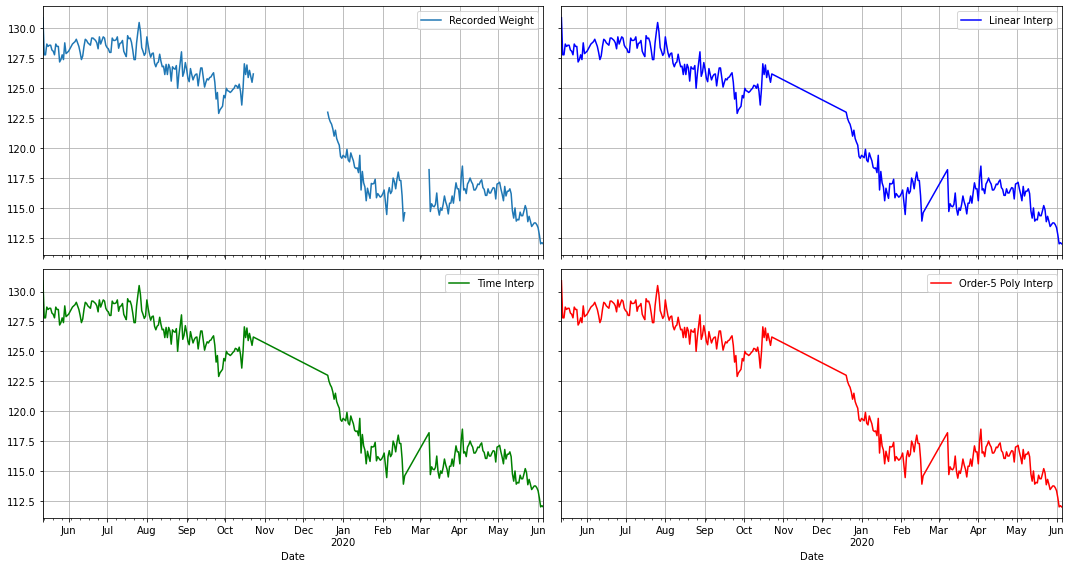

In [0]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(15,8),sharex=True,sharey=True,)

#fig.suptitle('Comparing interpolation methods')

#Plot the original weight log
clean.plot(y='Weight',ax=axs[0,0],grid=True,label = 'Recorded Weight')

#Plot the interpolated columns
clean.plot(y='Linear',ax=axs[0,1],style = 'b',grid=True,label = 'Linear Interp')
clean.plot(y='Time',ax=axs[1,0],style = 'g',grid=True,label = 'Time Interp')
clean.plot(y='Poly-5',ax=axs[1,1],style = 'r',grid=True,label = 'Order-5 Poly Interp')
fig.tight_layout()
plt.show()



In [0]:
fig.savefig('Interpolation_Methods')

So clearly the gap was too large, and all the interpolation methods result in a linear plot very quickly.

Instead, I'll just use the linear interpolation to plot a small dotted line to show the missing data on the final plot. To do this I'll need to set Nans to all the values that we have recorded data for.

In [0]:
clean.drop(labels=['Time','Poly-5'],axis=1)
clean['Missing'] = clean.Linear.copy()
clean['Missing'][clean.Weight.notna()] = np.nan #Creates boolean mask showing Trues for the not nulls in our original data. We then set NaN's in out linear column based on those Trues.

Let's also make a moving average column for our trend line


In [0]:
#Add 7-day moving average column to df and then add to plot
clean['MovAvg'] = clean.Weight.rolling(min_periods=1,window=7,center=True).mean()

We can now plot a new graph

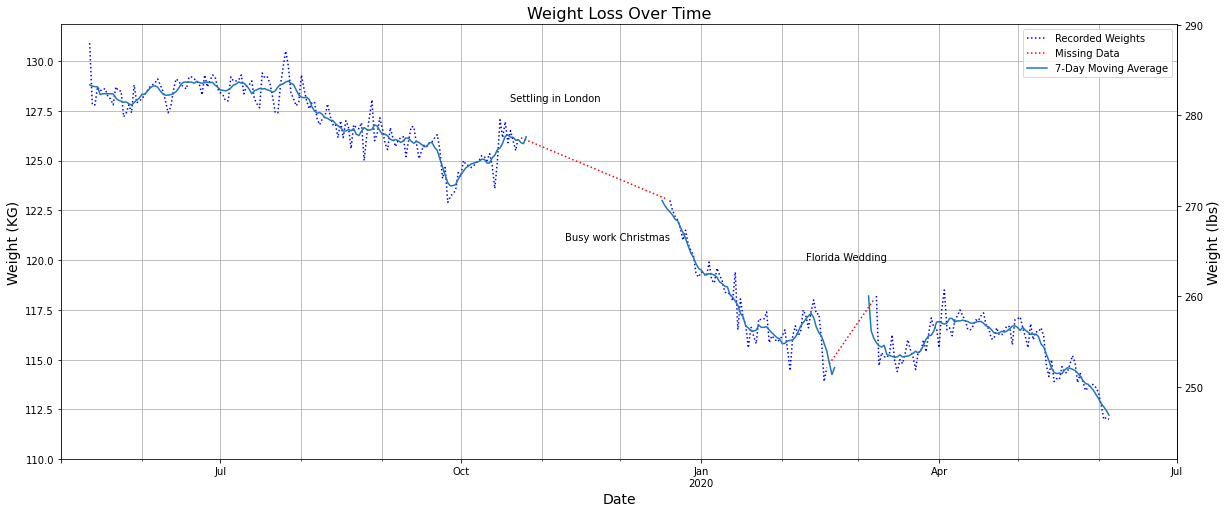

In [0]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_title('Weight Loss Over Time',fontsize=16)
ax.set_ylabel('Weight (KG)',fontsize=14)
ax.set_xlabel('Time',fontsize=14)


clean.plot(y='Weight',ax=ax, style='b:',label='Recorded Weights') # Original Log
clean.plot(y='Missing',ax=ax,style='r:',label='Missing Data') # Interpolated missing data using linear
clean.plot(y='MovAvg',ax=ax,label='7-Day Moving Average') # 7-Day moving average

#Extend axes to show perspective
ax.set_xlim(pd.Timestamp('2019-05-01'),pd.Timestamp('2020-07-01'))
ax.set_ylim(bottom=110)

#Annotate Graph
ax.annotate('Settling in London',('2019-10-20',128))
ax.annotate('Busy work Christmas',('2019-11-10',121))
ax.annotate('Florida Wedding',('2020-02-10',120))

#Add second vertical axis to show lbs
def KGtoLBS(x):
  return 2.2*x

def LBStoKG(x):
  return x/2.2

secaxy = ax.secondary_yaxis('right', functions=(KGtoLBS, LBStoKG))
secaxy.set_ylabel('Weight (lbs)',fontsize=14)

#Add grid and ticks
ax.grid(b=True,which='both')

plt.show()


In [0]:
fig.savefig('Weight_loss_annotated')